In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm

import glob

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
base_dir = 'COVID-19_Radiography_Dataset'

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']


In [4]:
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))


Found Metadata Files:
COVID.metadata.xlsx
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
Viral Pneumonia.metadata.xlsx


In [5]:
root_dir = 'COVID-19_Radiography_Dataset'

classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Initialize a dictionary to hold metadata DataFrames
metadata = {}

for cls in classes:
    # Special case for 'Viral Pneumonia'
    if cls == 'Viral Pneumonia':
        metadata_path = os.path.join(root_dir, 'Viral Pneumonia.metadata.xlsx')
    else:
        metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx')
        
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")

Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [6]:
class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_mask_pairs, transform=None, mask_transform=None):
        """
        Args:
            image_mask_pairs (list of tuples): List where each tuple contains (image_path, mask_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.image_mask_pairs = image_mask_pairs
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        image_path, mask_path, label = self.image_mask_pairs[idx]
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Load mask
        mask = Image.open(mask_path).convert('L')      # Grayscale for masks
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask, label

In [7]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Define mask transformations (only resizing and tensor conversion)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
classes

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [9]:
# Initialize a list to hold all mapped data
all_mapped_data = []
label_mapping = {cls: idx for idx, cls in enumerate(classes)}
# Iterate through each class and map images to masks
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    masks_dir = os.path.join(root_dir, cls, 'masks')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        mask_path = os.path.join(masks_dir, img_filename)  # Assuming mask has same filename
        
        # Check if mask exists
        if os.path.exists(mask_path):
            all_mapped_data.append((img_path, mask_path, label_mapping[cls]))
        else:
            print(f"Mask not found for image: {img_path}")

In [10]:
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'mask_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")

Mapped DataFrame:


,image_path,mask_path,label
0,COVID-19_Radiography_Dataset\COVID\images\COVI...,COVID-19_Radiography_Dataset\COVID\masks\COVID...,0
1,COVID-19_Radiography_Dataset\COVID\images\COVI...,COVID-19_Radiography_Dataset\COVID\masks\COVID...,0
2,COVID-19_Radiography_Dataset\COVID\images\COVI...,COVID-19_Radiography_Dataset\COVID\masks\COVID...,0
3,COVID-19_Radiography_Dataset\COVID\images\COVI...,COVID-19_Radiography_Dataset\COVID\masks\COVID...,0
4,COVID-19_Radiography_Dataset\COVID\images\COVI...,COVID-19_Radiography_Dataset\COVID\masks\COVID...,0


Total images mapped: 21165


In [11]:


# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")



Total samples: 21165
Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [12]:
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[2] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[2] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [13]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
train_labels = [sample[2] for sample in train_data]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([1.4634, 0.8802, 0.5192, 3.9318])


In [14]:
# Create Dataset instances
train_dataset = COVID19RadiographyDataset(train_data, transform=train_transform, mask_transform=mask_transform)
val_dataset = COVID19RadiographyDataset(val_data, transform=val_test_transform, mask_transform=mask_transform)
test_dataset = COVID19RadiographyDataset(test_data, transform=val_test_transform, mask_transform=mask_transform)

# Define batch size and number of workers
batch_size = 16
num_workers = 0

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 926, Val: 133, Test: 265


C:\Users\vedth\AppData\Local\Temp\ipykernel_6380\4171928423.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')


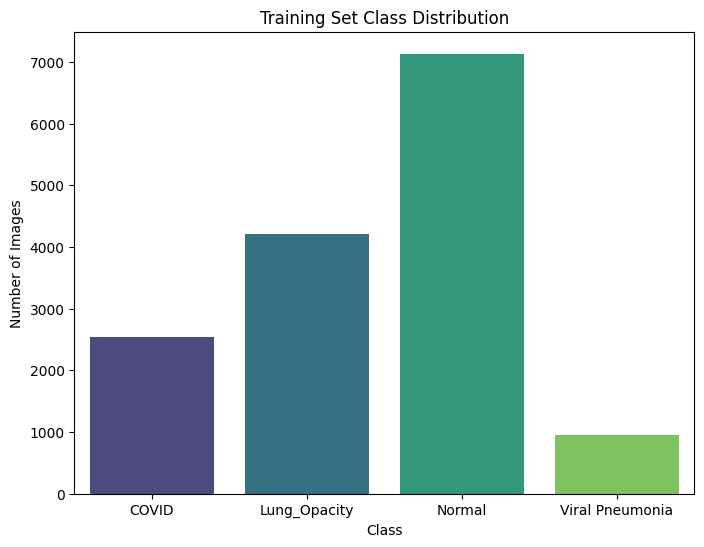

In [15]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

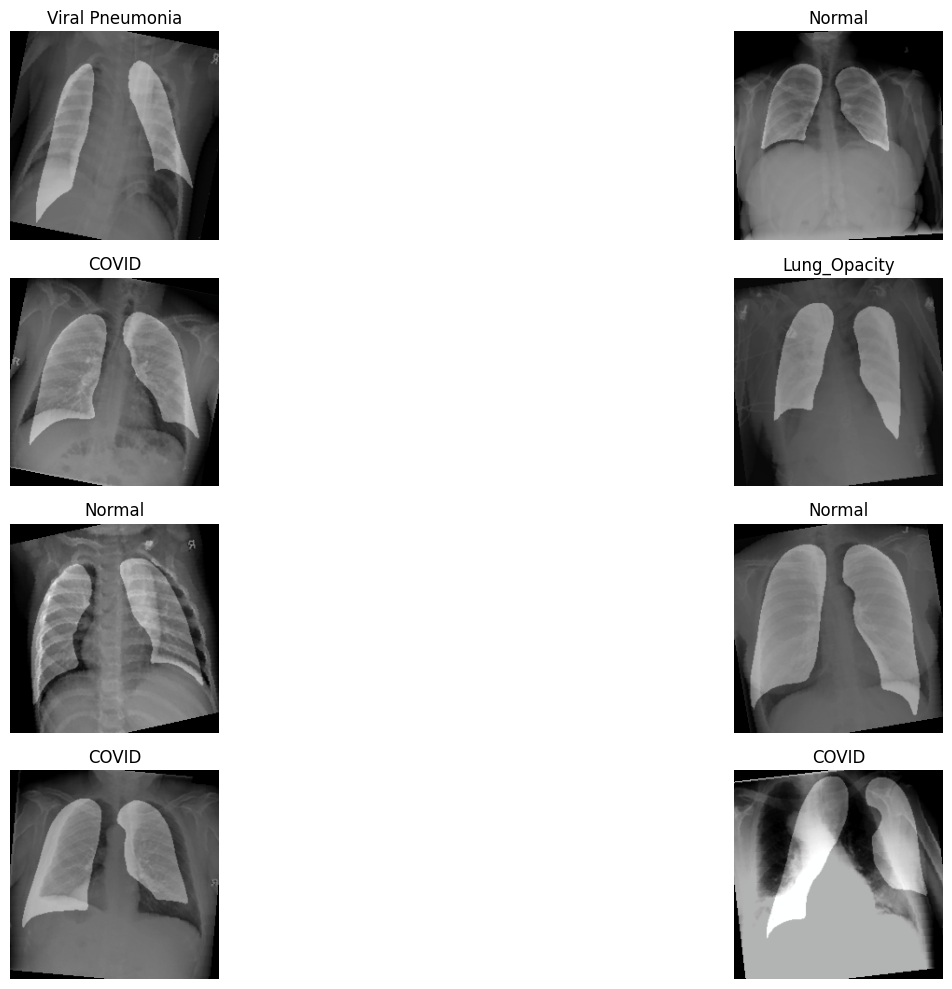

In [16]:
def imshow(img, title=None):
    """
    Displays a tensor as an image.
    
    Args:
        img (Tensor): Image tensor.
        title (str, optional): Title for the image.
    """
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                 np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def show_batch(loader, classes, num_images=8):
    """
    Displays a batch of images with their masks and labels.
    
    Args:
        loader (DataLoader): DataLoader to fetch the batch.
        classes (list): List of class names.
        num_images (int): Number of images to display.
    """
    images, masks, labels = next(iter(loader))
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(4, num_images//4, i+1)
        imshow(images[i])
        mask = masks[i].squeeze().numpy()
        plt.imshow(mask, cmap='gray', alpha=0.3)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a batch from the training set
show_batch(train_loader, classes, num_images=8)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [22]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)  # Modify last layer for binary classification
model = model.to(device)

In [23]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [24]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, masks, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [25]:
# Define number of epochs
num_epochs = 10

# Train the model
trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.4026 Acc: 0.8354


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1839 Acc: 0.9272

Epoch 2/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.2239 Acc: 0.9028


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1689 Acc: 0.9126

Epoch 3/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.1809 Acc: 0.9212


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1672 Acc: 0.9485

Epoch 4/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.1489 Acc: 0.9338


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1417 Acc: 0.9461

Epoch 5/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.1322 Acc: 0.9398


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1380 Acc: 0.9362

Epoch 6/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.1254 Acc: 0.9428


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1308 Acc: 0.9395

Epoch 7/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.1134 Acc: 0.9491


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1232 Acc: 0.9509

Epoch 8/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.0939 Acc: 0.9565


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1262 Acc: 0.9447

Epoch 9/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.0945 Acc: 0.9559


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1270 Acc: 0.9405

Epoch 10/10
----------


Train:   0%|          | 0/926 [00:00<?, ?it/s]

Train Loss: 0.0800 Acc: 0.9617


Val:   0%|          | 0/133 [00:00<?, ?it/s]

Val Loss: 0.1380 Acc: 0.9565

Best Validation Acc: 0.9565


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.inference_mode():
        for inputs, masks, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Testing:   0%|          | 0/265 [00:00<?, ?it/s]

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.97      0.98      0.98       723
   Lung_Opacity       0.93      0.93      0.93      1203
         Normal       0.95      0.95      0.95      2039
Viral Pneumonia       0.98      0.96      0.97       269

       accuracy                           0.95      4234
      macro avg       0.96      0.96      0.96      4234
   weighted avg       0.95      0.95      0.95      4234



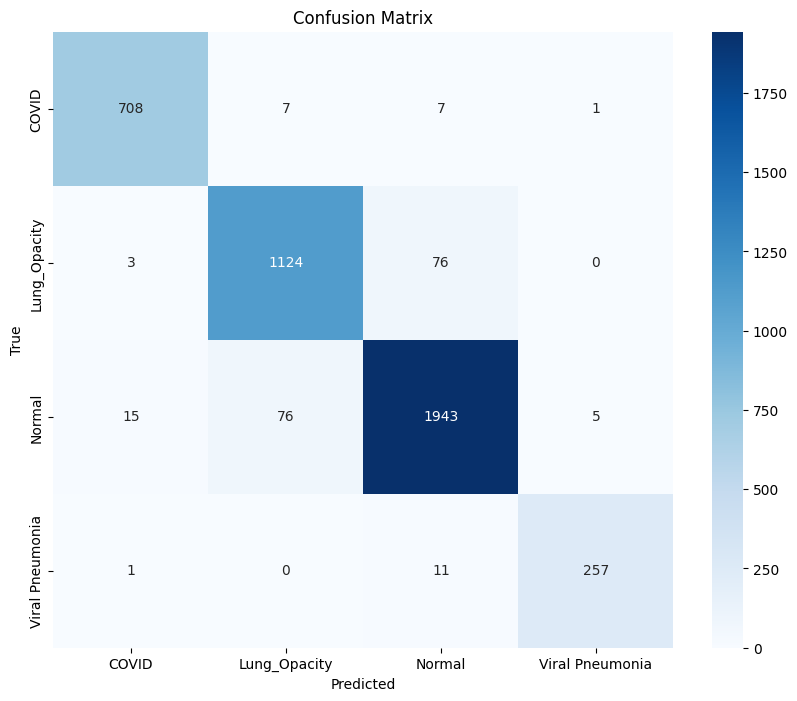

In [27]:
evaluate_model(trained_model, test_loader, classes)

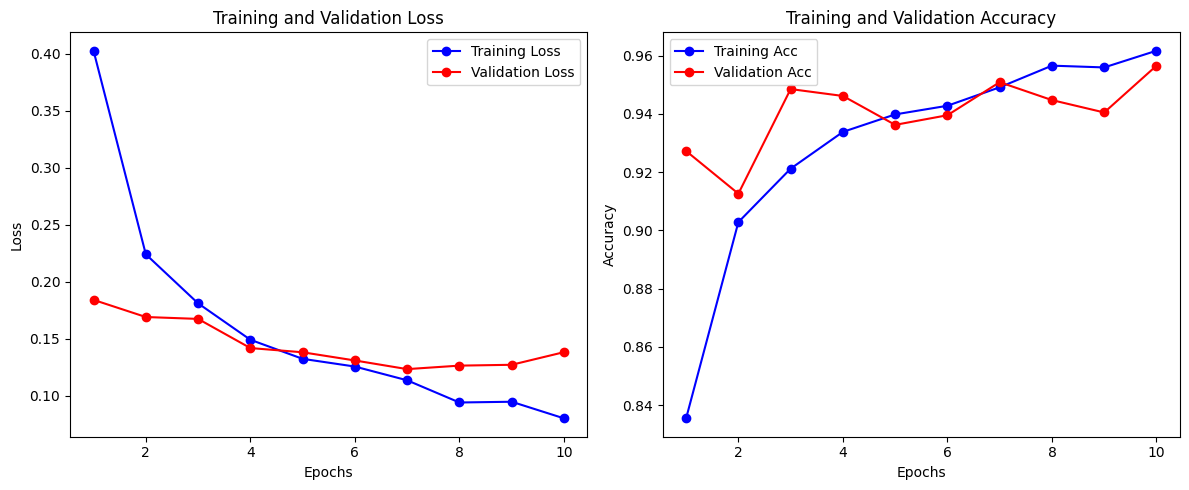

In [28]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

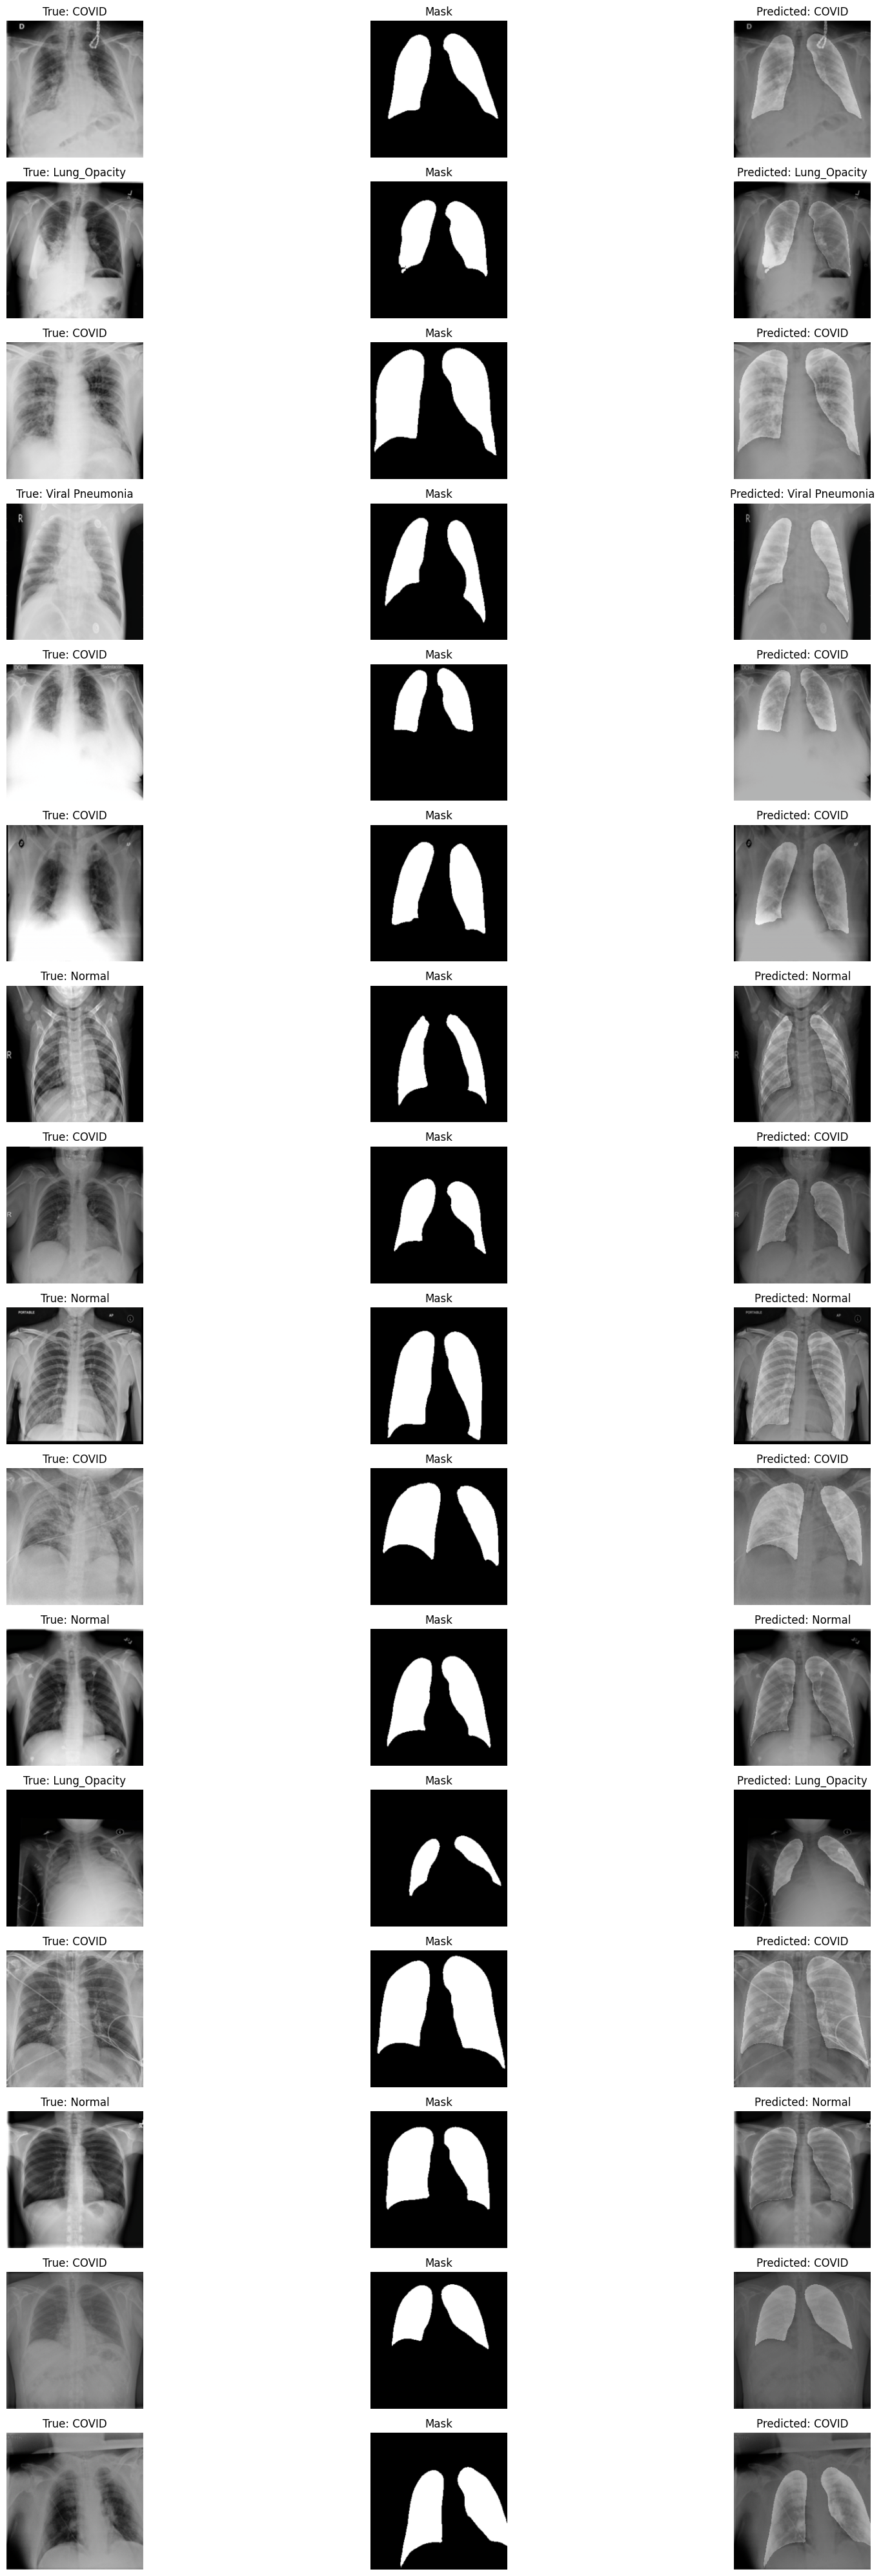

In [29]:
def visualize_predictions(model, dataloader, classes, num_images=18):
    model.eval()
    images, masks, labels = next(iter(dataloader))
    
    # Ensure we don't exceed the batch size
    num_images = min(num_images, images.size(0))
    
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(20, 40))  # Adjust figsize for larger output
    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 3, 3*i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}")
        plt.axis('off')
        
        # Mask
        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(img)
        plt.imshow(masks[i].squeeze(), cmap='gray', alpha=0.3)
        plt.title(f"Predicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 18 sample predictions
visualize_predictions(trained_model, test_loader, classes, num_images=18)

In [30]:
import torch

# Save model state_dict
torch.save(model.state_dict(), "model.pth")